In [1]:
import matplotlib.pyplot as plt
from numpy import *

## coupled AOM feedback code
A model for controlling the MOT laser power for the 4 MOT beams whose outputs are inside the vacuum chamber. By measuring the light from, e.g. MOT beam 1, which couples back through MOT beam 3, we can
stabilize it. If we keep track of how much we varied the power of MOT 1 when we adjusted AOM 1, we can divide out this effect when
we measure and correct MOT 3, which also depends on the diffraction efficiency of AOM 1.

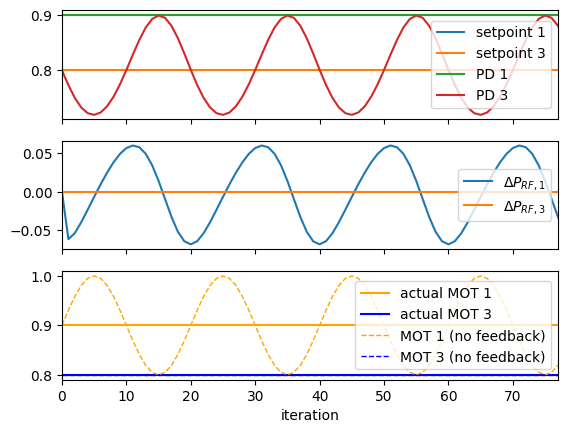

In [355]:
# example: there is a slowly varying sinusoidal noise on MOT 1,
# due, e.g., to temperature drifts in the lab which change the 
# fiber coupling. if we perfectly cancel the drift by changing
# AOM 1, we will see apparent drift of MOT 3 on PD 3. However,
# by using the scheme proposed above we will not wrongly
# adjust MOT 3 which has no real drift.

iters = 80

kp1 = kp3 = 2

error1 = zeros(iters)
error3 = zeros(iters)

eta1 = 1 # the diffraction efficiency of AOM 1 normalized to be 1
eta3 = 1 # the diffraction efficiency of AOM 3.

sp1 = 0.9 # arbitrary; in some units for the PD
sp3 = 0.8

PD1 = zeros(iters) # the value measured by the photodiode (PD)
PD3 = zeros(iters)
PD1[0] = sp1 # this is the baseline power seen at the PD
PD3[0] = sp3

delta_rf_power1 = zeros(iters) # the change in RF power compared to the last iteration
delta_rf_power3 = zeros(iters)

error1[0] = 0 #sp1 - PD1[0]*eta1*eta3 # 0. only valid at the moment the setpoint is defined
error3[0] = 0 #sp3 - PD3[0]*eta1*eta3

g1 = g3 = 0.5 # xfer function: d(diffraction efficiency)/d(RF power)

noise1 = lambda i: 0.1*sin(3*pi*i/30) # slow fiber drift
noise3 = lambda i: 0.0*i

dPD3 = dPD1 = 0 # percent change in power due to AOM compared to last cycle. starts at zero by definition

mot_power1 = zeros(iters) # the actual value of power at the atoms
mot_power3 = zeros(iters)

mot_power1[0] = PD1[0]/eta3 # the power that we would measure before AOM 3 if we could
mot_power3[0] = PD3[0]/eta1

for i in range(1,iters):
    
    # measure power on ch1. even if noise=0, a previous change to the other AOM will cause apparent fluctuation
    PD1[i] = (PD1[0] + noise1(i))*eta1*eta3
    
    # adjust AOM1 but factor out the change induced by AOM3 on the last cycle
    error1[i] = sp1 - PD1[i]/eta3 #PD1[i-1]/(1+dPD3)
    delta_rf_power1[i] = kp1*error1[i]
    PD1_temp = PD1[i] # the power on this iteration before correcting
    PD1[i] += g1*delta_rf_power1[i]
    dPD1 = (PD1[i] - PD1_temp)/PD1_temp # percent change in power due to AOM
    eta1 += dPD1 #*= (1+dPD1)
    
    # measure power on ch3
    PD3[i] = (PD3[0] + noise3(i))*eta1*eta3
    
    # adjust AOM3 but factor out the change induced by AOM1
    error3[i] = sp3 - PD3[i]/eta1 #(1+dPD1)
    delta_rf_power3[i] = kp3*error3[i]
    PD3_temp = PD3[i]
    PD3[i] += g3*delta_rf_power3[i]
    dPD3 = (PD3[i] - PD3_temp)/PD3_temp # percent change in power due to AOM
    eta3 += dPD3 #*= (1+dPD3)
    
    mot_power1[i] = PD1[i]/eta3
    mot_power3[i] = PD3[i]/eta1

steps = array(list(range(iters)))

fig,axes = plt.subplots(nrows=3,ncols=1,sharex=True)
ax,ax1,ax3 = axes
ax.plot(steps,[sp1]*iters,label='setpoint 1')
ax.plot(steps,[sp3]*iters,label='setpoint 3')

ax.plot(steps,PD1,label='PD 1')
ax.plot(steps,PD3,label='PD 3')

ax1.plot(steps,delta_rf_power1,label=r'$\Delta P_{RF,1}$')
ax1.plot(steps,delta_rf_power3,label=r'$\Delta P_{RF,3}$')

ax3.plot(steps,mot_power1,label='actual MOT 1',c='orange')
ax3.plot(steps,mot_power3,label='actual MOT 3',c='blue')
ax3.plot(steps,sp1+noise1(steps),label='MOT 1 (no feedback)',linestyle='--',c='orange',lw=1)
ax3.plot(steps,sp3+noise3(steps),label='MOT 3 (no feedback)',linestyle='--',c='blue',lw=1)

pd = list(PD1)+list(PD3)
minpd = min(pd)
maxpd = max(pd)
ax.set_ylim((0.99*minpd,1.01*maxpd))

powers = list(mot_power1)+list(mot_power3)
minp = min(powers)
maxp = max(powers)
# ax3.set_ylim((0.99*minp,1.01*maxp))
for ax in axes:
    ax.set_xlim((0,iters-3))
    ax.legend(loc='right')
ax.set_xlabel("iteration")
plt.show()

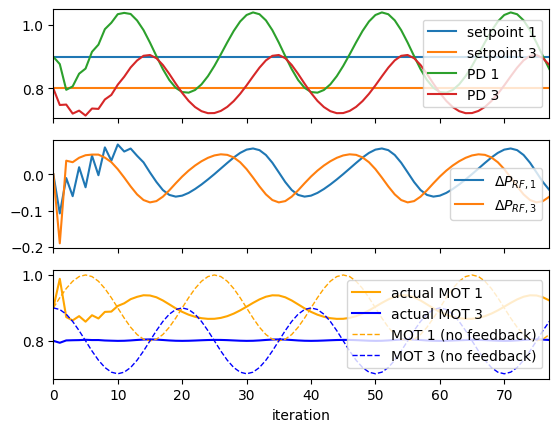

In [354]:
# example: both beams have a slowly varying noise, but out of phase

iters = 80

kp1 = 3.5
kp3 = 2

error1 = zeros(iters)
error3 = zeros(iters)

eta1 = 1 # the diffraction efficiency of AOM 1 normalized to be 1
eta3 = 1 # the diffraction efficiency of AOM 3.

sp1 = 0.9 # arbitrary; in some units for the PD
sp3 = 0.8

PD1 = zeros(iters) # the value measured by the photodiode (PD)
PD3 = zeros(iters)
PD1[0] = sp1 # this is the baseline power seen at the PD
PD3[0] = sp3

delta_rf_power1 = zeros(iters) # the change in RF power compared to the last iteration
delta_rf_power3 = zeros(iters)

error1[0] = 0 #sp1 - PD1[0]*eta1*eta3 # 0. only valid at the moment the setpoint is defined
error3[0] = 0 #sp3 - PD3[0]*eta1*eta3

g1 = g3 = 0.5 # xfer function: d(diffraction efficiency)/d(RF power)

noise1 = lambda i: 0.1*sin(3*pi*i/30) # slow fiber drift
noise3 = lambda i: 0.1*cos(3*pi*i/30) # slow fiber drift

dPD3 = dPD1 = 0 # percent change in power due to AOM compared to last cycle. starts at zero by definition

mot_power1 = zeros(iters) # the actual value of power at the atoms
mot_power3 = zeros(iters)

mot_power1[0] = PD1[0]/eta3 # the power that we would measure before AOM 3 if we could
mot_power3[0] = PD3[0]/eta1

for i in range(1,iters):
    
    # measure power on ch1. even if noise=0, a previous change to the other AOM will cause apparent fluctuation
    PD1[i] = (PD1[0] + noise1(i))*eta1*eta3
    
    # adjust AOM1 but factor out the change induced by AOM3 on the last cycle
    error1[i] = sp1 - PD1[i]/eta3 #PD1[i-1]/(1+dPD3)
    delta_rf_power1[i] = kp1*error1[i]
    PD1_temp = PD1[i] # the power on this iteration before correcting
    PD1[i] += g1*delta_rf_power1[i]
    dPD1 = (PD1[i] - PD1_temp)/PD1_temp # percent change in power due to AOM
    eta1 += dPD1 #*= (1+dPD1)
    
    # measure power on ch3
    PD3[i] = (PD3[0] + noise3(i))*eta1*eta3
    
    # adjust AOM3 but factor out the change induced by AOM1
    error3[i] = sp3 - PD3[i]/eta1 #(1+dPD1)
    delta_rf_power3[i] = kp3*error3[i]
    PD3_temp = PD3[i]
    PD3[i] += g3*delta_rf_power3[i]
    dPD3 = (PD3[i] - PD3_temp)/PD3_temp # percent change in power due to AOM
    eta3 += dPD3 #*= (1+dPD3)
    
    mot_power1[i] = PD1[i]/eta3
    mot_power3[i] = PD3[i]/eta1

steps = array(list(range(iters)))

fig,axes = plt.subplots(nrows=3,ncols=1,sharex=True)
ax,ax1,ax3 = axes
ax.plot(steps,[sp1]*iters,label='setpoint 1')
ax.plot(steps,[sp3]*iters,label='setpoint 3')

ax.plot(steps,PD1,label='PD 1')
ax.plot(steps,PD3,label='PD 3')

ax1.plot(steps,delta_rf_power1,label=r'$\Delta P_{RF,1}$')
ax1.plot(steps,delta_rf_power3,label=r'$\Delta P_{RF,3}$')

ax3.plot(steps,mot_power1,label='actual MOT 1',c='orange')
ax3.plot(steps,mot_power3,label='actual MOT 3',c='blue')
ax3.plot(steps,sp1+noise1(steps),label='MOT 1 (no feedback)',linestyle='--',c='orange',lw=1)
ax3.plot(steps,sp3+noise3(steps),label='MOT 3 (no feedback)',linestyle='--',c='blue',lw=1)

pd = list(PD1)+list(PD3)
minpd = min(pd)
maxpd = max(pd)
ax.set_ylim((0.99*minpd,1.01*maxpd))

powers = list(mot_power1)+list(mot_power3)
minp = min(powers)
maxp = max(powers)
# ax3.set_ylim((0.99*minp,1.01*maxp))
for ax in axes:
    ax.set_xlim((0,iters-3))
    ax.legend(loc='right')
ax.set_xlabel("iteration")
plt.show()